In [16]:
import pandas as pd
import os
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt



===========================================================
IMPORTANT NOTE: PROJECT DESCRIPTION
===========================================================

**Project:** Bitcoin & Google Trends Analysis  

**Description:**  
This script processes Bitcoin and Google Trends data to perform statistical computations and gain insights through VAR models and Granger causality tests. The project comprises a total of **13 functions**, with the execution flow starting from the `main()` function.

**Execution Flow:**  
1. **Data Preprocessing:**  
   - Cleans and merges Bitcoin price data from multiple years.  
   - Cleans and aggregates Google Trends data for corresponding periods.  

2. **Merging Datasets:**  
   - Aligns Bitcoin and Google Trends datasets by the `Date` column.  

3. **Statistical Analysis:**  
   - Computes descriptive statistics with optional outlier handling.  
   - Runs VAR models on key variables (e.g., log-RV, log-SQ, log-VO).  
   - Performs Granger causality tests to examine directional relationships.  

4. **Results & Visualization:**  
   - Generates Panel A (VAR coefficients table).  
   - Outputs statistical summaries and saves results as CSV files.  

**Required Input Files:**  
- **Bitcoin Data Files:**  
  - `2010.csv`, `2011.csv`, `2012.csv`, `2013.csv`, `2014.csv`, `2015.csv`, `2016.csv`, `2017.csv`  
  - **Important:** All Bitcoin data files must be located in the `Bitcoin_Data/` directory.  
  - **Note:** Bitcoin data is divided across multiple CSV files due to the large volume of data and annual separation. These files are merged during preprocessing to create a complete dataset.  

- **Google Trends Data Files:**  
  - `01-08-2010-31-12-2010.csv`, `01.01.2011-31.07.2011.csv`, etc. (total: 14 files)  
  - **Important:** All Google Trends data files must be located in the `Google_Trends_Data/` directory.  
  - **Note:** Google Trends only allows downloading data for limited timeframes in one file. To address this problem, the data was downloaded in multiple CSV files—each representing shorter timeframes—and then merged during preprocessing.  

**Directory Structure:**  
- Bitcoin data files: `Bitcoin_Data/`  
- Google Trends data files: `Google_Trends_Data/`  

**Execution Notes:**  
- Ensure all input files are correctly placed in their respective directories before running the script.  
- Execution starts with the `main()` function, which calls the other 12 supporting functions in a structured flow.  

===========================================================

====================================
"""


# 💰 1-Preprocess Bitcoin Data

This function processes raw Bitcoin CSV files, cleans them, merges the datasets, and computes essential financial metrics. The final dataset is saved as a single CSV file, ready for further analysis.

---

## **Key Steps in the Function**

### 🗂️ **1. Load and Parse Bitcoin Data**
   - **Objective**: Read multiple CSV files containing Bitcoin data.
   - **Operations**:
     - Select relevant columns: `timeOpen`, `open`, `high`, `low`, `close`, and `volume`.
     - Rename `timeOpen` to `Date` and convert it into a `datetime` format.
     - Ensure numeric columns (`open`, `high`, etc.) are valid by converting them to numeric and handling errors.

---

### 🔄 **2. Merge and Sort Data**
   - **Objective**: Combine all cleaned Bitcoin data files into one consolidated dataset.
   - **Operations**:
     - Concatenate cleaned data.
     - Sort the merged dataset by `Date`.

---

### 📈 **3. Calculate Financial Metrics**
   - **Objective**: Derive key metrics for analysis.
   - **Metrics**:
     - **`log-Returns`**: Logarithmic daily returns:
       \[
       \text{log-Returns} = \ln\left(\frac{\text{Close}_t}{\text{Close}_{t-1}}\right)
       \]
       - The first value is manually adjusted using a fixed reference (`previous_close_price` = 0.06976).
     - **`RV (Realized Volatility)`**: Squared log-Returns:
       \[
       \text{RV} = (\text{log-Returns})^2
       \]
     - **`log-RV`**: Natural logarithm of RV.
     - **`log-VO`**: Natural logarithm of trading volume.

---

### 💾 **4. Save Processed Data**
   - **Objective**: Export the cleaned and processed dataset to a CSV file.
   - **Output**:
     - A consolidated CSV file with computed metrics.

---

## **Output**
   - A single CSV file: `merged_bitcoin_data.csv`
   - Processed dataset with calculated metrics.

---


In [2]:
def preprocessing_Bitcoin_Data(bitcoin_csv_files, bitcoin_output_dir):
    """
    Preprocess Bitcoin CSV files:
    - Clean and merge multiple Bitcoin data files.
    - Compute financial metrics: log-Returns, RV, log-RV, log-VO.
    - Save the consolidated dataset to a CSV file.

    Args:
        bitcoin_csv_files (list): List of file paths to Bitcoin CSV files.
        bitcoin_output_dir (str): Directory to save the preprocessed data.

    Returns:
        pd.DataFrame: Cleaned and processed Bitcoin dataset.
    """


    # Ensure output directory exists
    os.makedirs(bitcoin_output_dir, exist_ok=True)
    bitcoin_file_combined = []

    # Step 1: Load and clean data from each file
    for file in bitcoin_csv_files:
        try:
            # Read the file
            df = pd.read_csv(file, sep=';')
            
            # Select and rename columns
            df = df[['timeOpen', 'open', 'high', 'low', 'close', 'volume']]
            df = df.rename(columns={'timeOpen': 'Date'})
            df = df.apply(lambda x: x.str.strip('"') if x.dtype == 'object' else x)

            # Convert 'Date' to datetime
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

            # Ensure numeric columns are valid
            numeric_cols = ['open', 'high', 'low', 'close', 'volume']
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Add cleaned data to the list
            bitcoin_file_combined.append(df)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Step 2: Merge and sort all cleaned files
    merged_data = pd.concat(bitcoin_file_combined, ignore_index=True)
    merged_data = merged_data.sort_values(by='Date').reset_index(drop=True)

    # Step 3: Calculate financial metrics
    previous_close_price = 0.06976  # Reference price for the first log-Returns
    merged_data['log-Returns'] = np.log(merged_data['close'] / merged_data['close'].shift(1))

    # Manually adjust the first value
    if not merged_data.empty:
        merged_data.loc[0, 'log-Returns'] = np.log(merged_data.loc[0, 'close'] / previous_close_price)

    # Realized Volatility (RV) and log-RV
    merged_data['RV'] = merged_data['log-Returns'] ** 2
    merged_data.loc[merged_data['RV'] <= 0, 'RV'] = np.nan
    merged_data['log-RV'] = np.log(merged_data['RV'])

    # Logarithmic Volume (log-VO)
    merged_data.loc[merged_data['volume'] <= 0, 'volume'] = np.nan
    merged_data['log-VO'] = np.log(merged_data['volume'])

    # Step 4: Save the processed dataset to a CSV file
    output_file = os.path.join(bitcoin_output_dir, "merged_bitcoin_data.csv")
    merged_data.to_csv(output_file, index=False)
    print(f"Merged Bitcoin data saved to: {output_file}")

    # Return the processed dataset
    return merged_data


## 📊 2-Calculate Descriptive Statistics with Outliers Handling

This function calculates descriptive statistics (mean, standard deviation, max, min, skewness, kurtosis) for a dataset, with optional outlier detection and removal. Key financial and statistical metrics like `stan-SQ`, `log-SQ`, `log-RV`, `log-Volume`, and `log-Returns` are computed for analysis.

---

## **Key Steps in the Function**

### 🔄 **1. Handle Invalid Data**
   - **Objective**: Filter out invalid or non-numeric values.
   - **Operations**:
     - Convert `SearchCount` to numeric, replacing invalid entries with `NaN`.
     - Remove zero or negative values for `SearchCount`, `volume`, and `RV` as they are not meaningful for logarithmic computations.

---

### 📈 **2. Compute Metrics**
   - **`stan-SQ`**: Standardized SearchCount:
     \[
     \text{stan-SQ} = \frac{\text{SearchCount}}{\text{mean}(\text{SearchCount})}
     \]
   - **`log-SQ`**: Logarithm of `stan-SQ`:
     \[
     \text{log-SQ} = \ln(\text{stan-SQ})
     \]

---

### ⚠️ **3. Outlier Detection (Optional)**
   - **Objective**: Identify and remove outliers based on z-scores.
   - **Operations**:
     - Compute z-scores for selected columns: `stan-SQ`, `log-SQ`, `log-RV`, `log-VO`, and `log-Returns`.
     - Remove rows where any z-score exceeds the threshold (default: 3.0).

---

### 🧮 **4. Compute Descriptive Statistics**
   - **Objective**: Generate summary statistics for key metrics.
   - **Metrics**:
     - Mean, Standard Deviation, Maximum, Minimum, Skewness, Kurtosis.
   - **Columns**:
     - `stan-SQ`, `log-SQ`, `log-RV`, `log-VO`, `log-Returns`.

---

### 💾 **5. Save and Return**
   - **Objective**: Save statistics to a CSV file and return the cleaned dataset along with the statistics.
   - **Output**:
     - CSV file with descriptive statistics.
     - Cleaned dataset for further analysis.

---


In [3]:
def calculate_descriptive_stats_with_outliers(merged_data, 
                                              output_csv='descriptive_statistics_cleaned.csv',
                                              save_csv=True,
                                              remove_outliers=False):
    """
    Calculate descriptive statistics for a dataset, with optional outlier handling.

    Args:
        merged_data (pd.DataFrame): Input dataset containing metrics like 'SearchCount', 'volume', and 'RV'.
        output_csv (str): File name to save descriptive statistics as a CSV.
        save_csv (bool): Whether to save the descriptive statistics to a file.
        remove_outliers (bool): Whether to remove outliers based on z-scores.

    Returns:
        stats_df (pd.DataFrame): Descriptive statistics for the dataset.
        merged_data (pd.DataFrame): Cleaned dataset after optional outlier removal.
    """
    
    
    # Create a copy of the dataset to preserve the original
    merged_data = merged_data.copy()

    # Step 1: Handle invalid and zero/negative values
    merged_data['SearchCount'] = pd.to_numeric(merged_data['SearchCount'], errors='coerce')
    merged_data.loc[merged_data['SearchCount'] <= 0, 'SearchCount'] = np.nan
    merged_data.loc[merged_data['volume'] <= 0, 'volume'] = np.nan
    merged_data.loc[merged_data['RV'] <= 0, 'RV'] = np.nan

    # Step 2: Compute stan-SQ and log-SQ
    mean_sq = merged_data['SearchCount'].mean(skipna=True)
    merged_data['stan-SQ'] = merged_data['SearchCount'] / mean_sq
    merged_data['log-SQ'] = np.log(merged_data['stan-SQ'])

    # Step 3: Outlier detection (optional)
    if remove_outliers:
        # Define columns for outlier detection
        columns_to_check = ['stan-SQ', 'log-SQ', 'log-RV', 'log-VO', 'log-Returns']
        merged_data = remove_outliers_zscore(merged_data, columns=columns_to_check, z_threshold=3.0)
        print(f"Outliers removed based on Z-Score threshold=3.0. Remaining rows: {len(merged_data)}")

    # Step 4: Compute descriptive statistics
    temp_data = merged_data[['stan-SQ', 'log-SQ', 'log-RV', 'log-VO', 'log-Returns']]
    stats = {
        'Mean': temp_data.mean(),
        'Std.Dev': temp_data.std(),
        'Max': temp_data.max(),
        'Min': temp_data.min(),
        'Skew': temp_data.skew(),
        'Kurtosis': temp_data.kurt()
    }
    stats_df = pd.DataFrame(stats).round(4)
    stats_df.index = ['stan-SQ', 'log-SQ', 'log-RV', 'log-VO', 'log-Returns']

    print("\nDescriptive Statistics:")
    print(stats_df)

    # Step 5: Save statistics to a CSV file (optional)
    if save_csv:
        stats_df.to_csv(output_csv, index=True)
        print(f"Descriptive statistics saved to: {output_csv}")

    return stats_df, merged_data


# 🧹 3-Clean Google Trends File

This function processes a single Google Trends CSV file to clean and prepare it for further analysis. The cleaned file is saved with a prefix `cleaned_` for easy identification.

---

## **Key Steps in the Function**

### 🗂 **1. File Preparation**
   - **Objective**: Identify the file to process and determine the output location.
   - **Operations**:
     - Extract base file name.
     - Define output path with a `cleaned_` prefix.

---

### 🧽 **2. Data Cleaning**
   - **Objective**: Remove invalid rows and ensure data consistency.
   - **Operations**:
     - Skip unnecessary header rows.
     - Remove rows with non-date content (e.g., "Gün").
     - Rename columns for clarity: `Date`, `SearchCount`.
     - Convert `SearchCount` to numeric and drop invalid entries.
     - Convert `Date` to a valid datetime format and drop invalid entries.

---

### 🔄 **3. Feature Calculation**
   - **Objective**: Add derived columns for analysis.
   - **Operations**:
     - Replace zero or negative `SearchCount` values with `NaN`.
     - Compute `log-SQ` as the natural logarithm of `SearchCount`.

---

### 💾 **4. Save Cleaned Data**
   - **Objective**: Save the processed file for further usage.
   - **Output**:
     - Cleaned CSV file saved to the specified directory.

---

### ⚠️ **5. Error Handling**
   - **Objective**: Handle any file reading or processing issues gracefully.
   - **Operations**:
     - Print descriptive error messages if processing fails.

---


In [4]:
def clean_google_trends_file(input_file, output_dir):
    """
    Cleans a single Google Trends CSV file and saves it with a 'cleaned_' prefix.

    Args:
        input_file (str): Path to the raw Google Trends CSV file.
        output_dir (str): Directory to save the cleaned file.

    Returns:
        None: Outputs the cleaned file to the specified directory.
    """
    import os
    import pandas as pd

    try:
        # Extract base file name and define output path
        base_name = os.path.splitext(os.path.basename(input_file))[0]
        output_file = os.path.join(output_dir, f"cleaned_{base_name}.csv")

        # Load the CSV file, skipping unnecessary rows
        df = pd.read_csv(input_file, skiprows=2, header=None)

        # Remove rows with non-date content (e.g., "Gün")
        df = df[df[0] != "Gün"]

        # Rename columns for clarity
        df.columns = ["Date", "SearchCount"]

        # Convert SearchCount to numeric and drop invalid entries
        df["SearchCount"] = pd.to_numeric(df["SearchCount"], errors="coerce")
        df = df.dropna(subset=["SearchCount"])

        # Convert Date column to datetime and drop invalid entries
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date"])

        # Replace zero or negative SearchCount values with NaN
        df.loc[df["SearchCount"] <= 0, "SearchCount"] = np.nan

        # Compute log-SQ
        df["log-SQ"] = np.log(df["SearchCount"])

        # Save the cleaned file
        df.to_csv(output_file, index=False)
        print(f"Cleaned file saved to: {output_file}")

    except Exception as e:
        # Handle errors and provide meaningful feedback
        print(f"Error processing {input_file}: {e}")


#### 🔗4- Merge Cleaned Google Trends Files

This function consolidates multiple cleaned Google Trends CSV files into a single dataset. It reads each file, combines the data, sorts it chronologically by date, and saves the resulting DataFrame to a specified CSV file.

---

## **Key Steps in the Function**

### 📂 **1. Initialize Empty DataFrame**
   - **Objective**: Create a container for combining data from multiple files.
   - **Operations**:
     - Define `merged_df` as an empty DataFrame.

---

### 🧹 **2. File Reading and Merging**
   - **Objective**: Read cleaned files and merge them into a single dataset.
   - **Operations**:
     - Loop through the list of cleaned files.
     - Read each file into a temporary DataFrame.
     - Concatenate the temporary DataFrame into `merged_df`.

---

### 🕒 **3. Sort and Reset Index**
   - **Objective**: Ensure the merged dataset is sorted chronologically.
   - **Operations**:
     - Sort the combined data by the `Date` column.
     - Reset the index to reflect the new order.

---

### 💾 **4. Save the Merged Data**
   - **Objective**: Persist the combined dataset for further use.
   - **Output**:
     - Save the merged dataset to the specified file path.

---

### ⚠️ **5. Error Handling**
   - **Objective**: Handle any issues that occur during file reading or merging.
   - **Operations**:
     - Print descriptive error messages for problematic files.

---


In [5]:
def merge_cleaned_trends_files(cleaned_files, output_file):
    """
    Merges multiple cleaned Google Trends CSV files into a single DataFrame and saves it.

    Args:
        cleaned_files (list of str): List of file paths for cleaned Google Trends CSV files.
        output_file (str): File path for the resulting merged CSV file.

    Returns:
        pd.DataFrame: The merged DataFrame sorted by date.
    """
    import pandas as pd

    # Initialize an empty DataFrame for merging
    merged_df = pd.DataFrame()

    for file in cleaned_files:
        try:
            print(f"Reading file: {file}")
            # Read the current cleaned file
            df = pd.read_csv(file)
            # Append the current file's data to the merged DataFrame
            merged_df = pd.concat([merged_df, df], ignore_index=True)
        except Exception as e:
            # Handle and report any errors during file reading
            print(f"Error reading {file}: {e}")

    # Sort the merged data by the 'Date' column and reset the index
    merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

    # Save the merged data to the specified output file
    merged_df.to_csv(output_file, index=False)
    print(f"Merged Google Trends file saved as: {output_file}")

    # Return the merged DataFrame
    return merged_df


# 🔗 6-Merge Bitcoin and Google Trends Data

This function merges two DataFrames: Bitcoin data and Google Trends data, using the `Date` column as the key. Before merging, the `Date` columns in both DataFrames are converted to string format to ensure consistency. The resulting merged DataFrame can also be saved as a CSV file.

---

## **Key Steps in the Function**

### 🗂 **1. Convert Date Columns to Strings**
   - **Objective**: Standardize the `Date` column format across both DataFrames.
   - **Operations**:
     - Use the helper function `convert_date_to_string` to format the `Date` column as strings.

---

### 🔗 **2. Merge the DataFrames**
   - **Objective**: Combine Bitcoin and Google Trends data into a single dataset.
   - **Operations**:
     - Perform a merge operation on the `Date` column.
     - Specify the join type (e.g., `inner`, `outer`, `left`, `right`).

---

### 🕒 **3. Sort and Reset Index**
   - **Objective**: Ensure the merged dataset is ordered by date.
   - **Operations**:
     - Sort the data by the `Date` column.
     - Reset the index for consistency.

---

### 💾 **4. Save the Merged Data**
   - **Objective**: Optionally save the merged dataset to a CSV file.
   - **Output**:
     - Save the merged data to the specified file path if `output_file` is provided.

---


In [6]:
def merge_bitcoin_and_trends_as_strings(bitcoin_df, trends_df, output_file=True, how="inner"):
    """
    Merges Bitcoin and Google Trends DataFrames on the 'Date' column.
    
    Steps:
        1. Convert 'Date' columns in both DataFrames to string format.
        2. Merge the two DataFrames using the 'Date' column.
        3. Sort the merged DataFrame by date and reset the index.
        4. Optionally save the merged DataFrame to a CSV file.

    Args:
        bitcoin_df (pd.DataFrame): The Bitcoin DataFrame.
        trends_df (pd.DataFrame): The Google Trends DataFrame.
        output_file (str or bool): Path to save the merged file, or False to skip saving.
        how (str): Type of merge operation ('inner', 'outer', 'left', 'right').

    Returns:
        pd.DataFrame: The merged DataFrame, sorted by date.
    """
    

    # Convert 'Date' columns to string format in both DataFrames
    bitcoin_df = convert_date_to_string(bitcoin_df, date_col='Date')
    trends_df = convert_date_to_string(trends_df, date_col='Date')

    # Merge the DataFrames on the 'Date' column
    merged_df = pd.merge(bitcoin_df, trends_df, on="Date", how=how)

    # Sort the merged DataFrame by 'Date' and reset the index
    merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

    # Save the merged DataFrame to a CSV file if output_file is specified
    if output_file:
        merged_df.to_csv(output_file, index=False)
        print(f"Final merged (Bitcoin + Trends) data saved to: {output_file}")

    # Return the merged DataFrame
    return merged_df


# 📅 7-Convert Date Column to String Format

This utility function converts a specified date column in a DataFrame into a standardized string format (`YYYY-MM-DD`). The function handles invalid date entries gracefully by converting them to `NaT` (Not a Time), ensuring data consistency.

---

## **Key Steps in the Function**

### 1️⃣ **Convert to Datetime Format**
   - **Objective**: Ensure the column values are valid date objects.
   - **Operations**:
     - Use `pd.to_datetime()` to parse and convert the column values to datetime objects.
     - Invalid entries will be coerced to `NaT`.

---

### 2️⃣ **Convert to String Format**
   - **Objective**: Transform datetime objects into a string representation.
   - **Operations**:
     - Use `.dt.strftime('%Y-%m-%d')` to standardize the date format as `YYYY-MM-DD`.

---

### 🔄 **Return the Updated DataFrame**
   - **Objective**: Provide a DataFrame with the updated date column.
   - **Output**:
     - Returns the modified DataFrame with the specified date column converted to string format.
---


In [7]:
def convert_date_to_string(df, date_col='Date'):
    """
    Converts the specified date column in a DataFrame to string format (YYYY-MM-DD).

    Steps:
        1. Convert the 'date_col' to datetime format, handling errors by coercing invalid entries to NaT.
        2. Convert the datetime column to a standardized string format 'YYYY-MM-DD'.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_col (str): The name of the date column to convert.

    Returns:
        pd.DataFrame: The updated DataFrame with the 'date_col' converted to string format.
    """
    # Convert the specified column to datetime format, coercing errors to NaT
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Convert the datetime column to string format (YYYY-MM-DD)
    df[date_col] = df[date_col].dt.strftime('%Y-%m-%d')

    return df


# 📊 8-Vector Autoregressive (VAR) Models and Granger Causality Analysis

This script runs three distinct VAR models on time series data and evaluates Granger causality relationships between variables. It is especially suited for economic and financial datasets, where understanding variable interdependencies over time is critical.

---

## **Key Components**

### 1️⃣ **Significance Stars**
   - **Purpose**: Denote the statistical significance of p-values in results.
   - **Thresholds**:
     - `p < 0.01` → `***`
     - `p < 0.05` → `**`
     - `p < 0.1` → `*`

---

### 2️⃣ **Granger Causality Test**
   - **Objective**: Test whether one time series can predict another.
   - **Operations**:
     - Uses `var_result.test_causality()` from the VAR model results.
     - Evaluates causality relationships (e.g., `log-RV` → `log-SQ`).

---

### 3️⃣ **VAR Models**
   - **Purpose**: Fit and analyze relationships between time series variables over different lag periods.
   - **Models**:
     - **Model 1**: `log-RV` ↔ `log-SQ`
     - **Model 2**: `log-SQ` ↔ `log-VO`
     - **Model 3**: `log-SQ`, `log-RV`, `log-VO`, `log-Returns`

---

### 4️⃣ **Panel B: Granger Causality**
   - **Goal**: Summarize causality test results in a panel format.
   - **Tests**:
     - Does variable X Granger-cause variable Y?
     - e.g., `log-RV` → `log-SQ` and vice versa.

---

## **Workflow**

1. **Data Preparation**:
   - Handle missing values and sort the dataset by `Date`.

2. **Run VAR Models**:
   - Fit models for subsets of variables using a fixed lag (e.g., 7).

3. **Summarize Results**:
   - Print coefficients and statistical summaries for each model.

4. **Perform Granger Tests**:
   - Evaluate bidirectional relationships between variables.

---

## **Output**
   - Summaries for each VAR model.
   - Granger causality test results indicating significant relationships.

---


In [8]:


def significance_stars(p_value):
    """
    Return significance stars based on p-value:
    - p < 0.01 → ***
    - p < 0.05 → **
    - p < 0.1  → *
    """
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

def print_granger_test(var_result, caused, causing_vars):
    """
    Conduct a Granger causality test between variables.

    Args:
        var_result: VAR model results.
        caused: Dependent variable (str).
        causing_vars: Independent variable(s) (str or list).
    """
    import numpy as np
    if isinstance(causing_vars, str):
        causing_vars = [causing_vars]
    
    test_res = var_result.test_causality(caused=caused, causing=causing_vars, kind='f')
    stat = test_res.test_statistic
    pval = test_res.pvalue
    
    if isinstance(stat, (list, np.ndarray)):
        stat = stat[0]
    if isinstance(pval, (list, np.ndarray)):
        pval = pval[0]
    
    stars = significance_stars(pval)
    print(f"{causing_vars} → {caused}: F={stat:.4f}, p={pval:.4g}{stars}")

def run_var_models(final_df, max_lags=7, force_lags=7):
    """
    Run three VAR models and perform Granger causality tests.

    Args:
        final_df: DataFrame with time series data.
        max_lags: Maximum lags for BIC/AIC selection.
        force_lags: Fixed lag count for all models.
    Returns:
        Results from all three VAR models.
    """
    print("\n=== Run VAR Models ===")
    
    data = final_df.dropna().copy()
    data.sort_values(by='Date', inplace=True, ignore_index=True)
    
    # Model 1: log-RV and log-SQ
    model_1_data = data[['log-RV', 'log-SQ']].copy()
    var_model_1 = VAR(model_1_data)
    var_result_1 = var_model_1.fit(force_lags)

    print("\n=== Model 1 Summary ===")
    print(var_result_1.summary())

    # Model 2: log-SQ and log-VO
    model_2_data = data[['log-SQ', 'log-VO']].copy()
    var_model_2 = VAR(model_2_data)
    var_result_2 = var_model_2.fit(force_lags)

    print("\n=== Model 2 Summary ===")
    print(var_result_2.summary())

    # Model 3: log-SQ, log-RV, log-VO, log-Returns
    model_3_data = data[['log-SQ','log-Returns']].copy()
    var_model_3 = VAR(model_3_data)
    var_result_3 = var_model_3.fit(force_lags)

    print("\n=== Model 3 Summary ===")
    print(var_result_3.summary())

    # Panel B: Granger Tests
    print("\n=== Granger Causality Tests ===")
    print("\n[Model 1]")
    print_granger_test(var_result_1, 'log-SQ', 'log-RV')
    print_granger_test(var_result_1, 'log-RV', 'log-SQ')

    print("\n[Model 2]")
    print_granger_test(var_result_2, 'log-VO', 'log-SQ')
    print_granger_test(var_result_2, 'log-SQ', 'log-VO')

    print("\n[Model 3]")
    print_granger_test(var_result_3, 'log-SQ', 'log-Returns')
    print_granger_test(var_result_3, 'log-Returns', 'log-SQ')

    return var_result_1, var_result_2, var_result_3


# 📊 9-Panel A: VAR Model Coefficients Table

This script generates a structured table summarizing coefficients from three VAR models, similar to "Panel A" in academic papers.

---

## **Key Components**

### 1️⃣ **Helper Functions**
   - **`get_coefficient_str`**:
     - Extracts coefficient and p-value for a specific parameter in a VAR result.
     - Formats output as `value + significance stars` (e.g., `0.1625***`).

---

### 2️⃣ **Row Labels**
   - **Lagged Variables**:
     - Represent past values of variables affecting current values (e.g., `SQ(t-1)`).
   - **Constants**:
     - Represent intercept terms.

---

### 3️⃣ **Column Structure**
   - **MultiIndex** Columns:
     - Organized by model (e.g., Model 1, Model 2, Model 3) and dependent equations (e.g., `RV_t`, `SQ_t`).

---

### 4️⃣ **Mapping Variables**
   - **Row Labels ↔ VAR Parameters**:
     - E.g., `SQ(t-1)` ↔ `L1.log-SQ`.

---

### 5️⃣ **Output Table**
   - Rows: Lagged variables and constants.
   - Columns: Coefficients for each dependent variable in each model.

---

## **Workflow**

1. **Define Row Labels**:
   - Specify lagged variables and constants.

2. **Map Variables**:
   - Create a dictionary linking row labels to parameter names.

3. **Create Columns**:
   - Use a MultiIndex structure for models and dependent variables.

4. **Populate Table**:
   - Use `get_coefficient_str` to extract and format coefficients for each combination of row, column, and model.

---

## **Output**
   - A DataFrame summarizing coefficients and significance levels for all models.

---


In [9]:
def get_coefficient_str(var_result, equation_name, param_name):
    """
    Extracts coefficient and p-value for a parameter in a VAR model result,
    formats it with significance stars.
    
    Args:
        var_result: VAR model results object.
        equation_name: Name of the dependent variable equation (e.g., 'log-RV').
        param_name: Parameter name (e.g., 'L1.log-SQ').
    Returns:
        Formatted coefficient string (e.g., '0.1625***').
    """
    try:
        coef_val = var_result.params.loc[equation_name, param_name]
        p_val = var_result.pvalues.loc[equation_name, param_name]
        star = significance_stars(p_val)
        return f"{coef_val:.4f}{star}"
    except KeyError:
        return ""

def produce_panel_a_table(var_res1, var_res2, var_res3):
    """
    Generates a structured table summarizing coefficients from three VAR models.
    
    Args:
        var_res1: Results from Model 1 (log-RV, log-SQ).
        var_res2: Results from Model 2 (log-SQ, log-VO).
        var_res3: Results from Model 3 (log-SQ, log-RV, log-VO, log-Returns).
    Returns:
        DataFrame: Panel A table with coefficients and significance stars.
    """
    row_labels = [
        "SQ(t-1)", "SQ(t-2)", "SQ(t-3)", "SQ(t-4)", "SQ(t-5)", "SQ(t-6)", "SQ(t-7)",
        "RV(t-1)", "RV(t-2)", "RV(t-3)", "RV(t-4)", "RV(t-5)", "RV(t-6)", "RV(t-7)",
        "VO(t-1)", "VO(t-2)", "VO(t-3)", "VO(t-4)", "VO(t-5)", "VO(t-6)", "VO(t-7)",
        "R(t-1)", "R(t-2)", "R(t-3)", "R(t-4)", "R(t-5)",
        "Constant"
    ]

    row_to_param = {
        "SQ(t-1)": "L1.log-SQ", "SQ(t-2)": "L2.log-SQ", "SQ(t-3)": "L3.log-SQ",
        "SQ(t-4)": "L4.log-SQ", "SQ(t-5)": "L5.log-SQ", "SQ(t-6)": "L6.log-SQ", "SQ(t-7)": "L7.log-SQ",
        "RV(t-1)": "L1.log-RV", "RV(t-2)": "L2.log-RV", "RV(t-3)": "L3.log-RV",
        "RV(t-4)": "L4.log-RV", "RV(t-5)": "L5.log-RV", "RV(t-6)": "L6.log-RV", "RV(t-7)": "L7.log-RV",
        "VO(t-1)": "L1.log-VO", "VO(t-2)": "L2.log-VO", "VO(t-3)": "L3.log-VO",
        "VO(t-4)": "L4.log-VO", "VO(t-5)": "L5.log-VO", "VO(t-6)": "L6.log-VO", "VO(t-7)": "L7.log-VO",
        "R(t-1)": "L1.log-Returns", "R(t-2)": "L2.log-Returns", "R(t-3)": "L3.log-Returns",
        "R(t-4)": "L4.log-Returns", "R(t-5)": "L5.log-Returns",
        "Constant": "const"
    }

    columns = pd.MultiIndex.from_tuples([
        ("Model 1", "RV_t"), ("Model 1", "SQ_t"),
        ("Model 2", "VO_t"),
        ("Model 3", "R_t"), ("Model 3", "SQ_t"),
    ])

   


# =============================================================
# 📊 10-run_and_plot_irf Function
# =============================================================
# This function performs the following tasks:
# 
# 🛠 **Step 1: Data Preparation**
#    - Selects relevant columns (`log-SQ`, `log-RV`, `log-VO`, `close`).
#    - Creates a new DataFrame specifically for IRF calculation.
#
# 🧮 **Step 2: Log-Returns Calculation**
#    - Computes `log-Returns` using the formula:
#      ln(Close_t / Close_t-1).
#    - Adjusts the initial value using a predefined `initial_close_price`.
#    - Applies a sign change to match the desired output alignment.
#
# 🧹 **Step 3: Data Cleaning**
#    - Replaces invalid values (e.g., `inf`, `-inf`) with NaN.
#    - Drops rows containing NaN values for essential columns.
#
# 🤖 **Step 4: VAR Model**
#    - Fits a Vector Autoregression (VAR) model on the cleaned dataset.
#    - Uses a maximum lag of 7 as specified.
#
# 📈 **Step 5: IRF Plot**
#    - Generates and displays Impulse Response Functions (IRFs).
#    - Optionally saves the IRF plot to the provided `save_path`.
#
# =============================================================


In [10]:
def run_and_plot_irf(original_df, steps=100, save_path=None):
    """
    Prepare data for IRF calculation, run the VAR model, and plot IRF.

    Args:
        original_df (pd.DataFrame): Original merged dataset.
        steps (int): Number of steps to plot in IRF.
        save_path (str): Path to save the IRF plot, if specified.
    """
    # Step 1: Create a new DataFrame for IRF calculation
    irf_data = original_df[['Date', 'log-SQ', 'log-RV', 'log-VO', 'close']].copy()

    # Step 2: Recalculate log-returns specifically for IRF
    irf_data['log-Returns'] = np.log(irf_data['close'] / irf_data['close'].shift(1))

    initial_close_price = 0.06976
    if not irf_data.empty:
        irf_data.loc[0, 'log-Returns'] = np.log(irf_data.loc[0, 'close'] / initial_close_price)

    # *** İşaret Değişikliği Burada Ekleniyor ***
    irf_data['log-Returns'] = -irf_data['log-Returns']

    # Step 3: Drop invalid values (e.g., -inf, inf, NaN)
    irf_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    irf_data.dropna(subset=['log-Returns', 'log-SQ', 'log-RV', 'log-VO'], inplace=True)

    # Step 4: Fit VAR model
    var_model = VAR(irf_data[['log-SQ', 'log-RV', 'log-VO', 'log-Returns']])
    var_result = var_model.fit(maxlags=7)

    # Step 5: Plot IRF
    irf = var_result.irf(steps)
    fig = irf.plot(orth=False)
    plt.suptitle('Impulse Response Functions (IRF)', fontsize=16)
    
    if save_path:
        plt.savefig(save_path)
        print(f"IRF plot saved to {save_path}")
    plt.show()



# =============================================================
# 📊 Subsample VAR Analysis: Replicating the Paper's Approach
# =============================================================
# As described in the paper, subsampling is a key step to analyze 
# how the relationships between Bitcoin-related variables evolve 
# over time. The goal is to replicate the paper's methodology 
# and verify if the findings hold true with our processed dataset.

# 🧐 **Why Subsampling?**
# 1️⃣ **Temporal Variability**:
#    - In the paper, it is suggested that relationships between 
#      volatility (`log-RV`), volume (`log-VO`), returns, and 
#      search queries are not stable over time.
#    - Subsampling helps us investigate if these relationships 
#      change across different time periods.

# 2️⃣ **Structural Breaks**:
#    - The paper identifies October 2013 as a key structural break, 
#      based on the Bai and Perron (2003) methodology, which detects 
#      significant breakpoints in time series data.
#    - Subsample analysis enables us to examine whether the dynamics 
#      of Bitcoin's attention drivers differ before and after this date.

# 3️⃣ **Findings from the Paper**:
#    - The paper highlights that before October 2013 (Subsample 1), 
#      variables like realized volatility (`log-RV`) and returns 
#      have no significant influence on search queries.
#    - However, after October 2013 (Subsample 2), these variables 
#      become significant predictors, suggesting a shift in investor 
#      behavior and attention dynamics.

# 4️⃣ **Improved Interpretability**:
#    - By dividing the data into these two periods, the analysis 
#      becomes more focused and aligned with the findings in the 
#      referenced paper.

# 🎯 **Objective**:
# - To follow the paper's methodology and split the dataset into 
#   two subsamples:
#   - Subsample 1: 1st July 2012 to 27th October 2013.
#   - Subsample 2: 28th October 2013 to 30th June 2017.
# - To analyze whether the relationships between variables, such as 
#   realized volatility and search queries, align with the changes 
#   described in the paper.

# =============================================================


In [11]:
def run_subsample_var_analysis(final_df, max_lags=7, force_lags=7):
    """
    Perform VAR analysis on subsamples of the data.

    Args:
        final_df (pd.DataFrame): Full merged dataset.
        s
        max_lags (int): Maximum lags for BIC/AIC selection.
        force_lags (int): Fixed lag count for all models.
    Returns:
        dict: Dictionary containing VAR results and Panel A tables for each subsample.
    """

    subsample_ranges = [
        ("2012-07-01", "2013-10-27"),  # Subsample 1
        ("2013-10-28", "2017-06-30")   # Subsample 2
    ]
    subsample_results = {}

    for i, (start_date, end_date) in enumerate(subsample_ranges, start=1):
        print(f"\n=== Subsample {i}: {start_date} to {end_date} ===")
        
        # Filter data for the subsample
        subsample_data = final_df[(final_df['Date'] >= start_date) & (final_df['Date'] <= end_date)].copy()
        subsample_data = subsample_data.dropna()  # Drop missing values
        
        # Run VAR models on the subsample
        var_res1, var_res2, var_res3 = run_var_models(subsample_data, max_lags=max_lags, force_lags=force_lags)
        
        # Generate Panel A table for the subsample
        df_panelA = produce_panel_a_table(var_res1, var_res2, var_res3)
        
        # Store results
        subsample_results[f"Subsample {i}"] = {
            "start_date": start_date,
            "end_date": end_date,
            "var_results": (var_res1, var_res2, var_res3),
            "panel_a_table": df_panelA
        }
        
        


    return subsample_results


# 🛠️ **12-Main Function Workflow**

The `main()` function orchestrates the entire data pipeline, from preprocessing raw data to generating descriptive statistics and running VAR models.

---

## **Outline**

### 1️⃣ **Directories and File Paths**
   - Specifies input/output directories for Bitcoin and Google Trends data.
   - Defines filenames for raw and processed CSV files.

---

### 2️⃣ **Data Preprocessing**
   - **Bitcoin Data**:
     - Reads raw Bitcoin data.
     - Cleans, merges, and computes additional columns (`log-Returns`, `RV`).
     - Saves the processed Bitcoin data to a new CSV file.
   - **Google Trends Data**:
     - Cleans individual CSV files.
     - Merges cleaned files into a single dataset.

---

### 3️⃣ **Data Integration**
   - Merges Bitcoin and Google Trends datasets on the `Date` column.
   - Produces a final merged DataFrame (`final_merged_df`) with synchronized data.

---

### 4️⃣ **Descriptive Statistics**
   - Computes statistics (mean, standard deviation, skewness, etc.) for key variables.
   - Optionally removes outliers using Z-score thresholds.

---

### 5️⃣ **VAR Modeling**
   - Fits three VAR models:
     1. **Model 1**: Includes `log-RV` and `log-SQ`.
     2. **Model 2**: Includes `log-SQ` and `log-VO`.
     3. **Model 3**: Includes `log-SQ`, `log-RV`, `log-VO`, and `log-Returns`.
   - Generates a "Panel A" style table summarizing the VAR model coefficients.

---

## **Outputs**
   - Cleaned Bitcoin and Google Trends datasets.
   - Merged dataset (`final_merged_df`).
   - Descriptive statistics CSV (`stats_including_outliers.csv`).
   - "Panel A" table summarizing VAR coefficients.

---


In [12]:
def main():
    """
    Main function to execute the complete data processing and modeling pipeline.
    Steps:
    1. Preprocess Bitcoin and Google Trends data.
    2. Merge datasets on 'Date'.
    3. Compute descriptive statistics.
    4. Fit VAR models and generate 'Panel A' table.
    """

    # Step 1: Directories and file paths
    bitcoin_input_dir = "Bitcoin_Data"
    bitcoin_output_dir = "Preprocessed_Bitcoin_Data"
    google_trends_input_dir = "Google_Trends_Data"
    google_trends_output_dir = "Preprocessed_Google_Trends_Data"
    final_output_csv = "final_merged_data.csv"

    bitcoin_csv_files = [
        os.path.join(bitcoin_input_dir, f"{year}.csv") for year in range(2010, 2018)
    ]
    csv_files = [
        "01-08-2010-31-12-2010", "01.01.2011-31.07.2011", "01-08-2011-31-12-2011",
        "01-01-2012-31.07.2012", "01-08-2012-31-12-2012", "01-01-2013-31.07.2013",
        "01-08-2013-31-12-2013", "01-01-2014-31.07.2014", "01-08-2014-31-12-2014",
        "01-01-2015-31.07.2015", "01-08-2015-31-12-2015", "01-01-2016-31.07.2016",
        "01-08-2016-31-12-2016", "01-01-2017-31.07.2017"
    ]

    # Step 2: Preprocess Bitcoin data
    merged_bitcoin_data = preprocessing_Bitcoin_Data(bitcoin_csv_files, bitcoin_output_dir)

    # Step 3: Preprocess Google Trends data
    os.makedirs(google_trends_output_dir, exist_ok=True)
    for file_name in csv_files:
        input_file = os.path.join(google_trends_input_dir, f"{file_name}.csv")
        clean_google_trends_file(input_file, google_trends_output_dir)

    cleaned_files = [
        os.path.join(google_trends_output_dir, f"cleaned_{file_name}.csv")
        for file_name in csv_files
    ]
    merged_trends_output_file = "merged_cleaned_trends_data.csv"
    merged_trends_df = merge_cleaned_trends_files(cleaned_files, merged_trends_output_file)

    # Step 4: Merge Bitcoin and Google Trends datasets
    final_merged_df = merge_bitcoin_and_trends_as_strings(
        bitcoin_df=merged_bitcoin_data,
        trends_df=merged_trends_df,
        output_file=final_output_csv,
        how="inner"
    )

    print("\n>>> FINAL MERGED DF (head):")
    print(final_merged_df.head())
    print("\n>>> FINAL MERGED DF dtypes:")
    print(final_merged_df.dtypes)

    # Step 5: Descriptive statistics
    stats_including_outliers, df_including_outliers = calculate_descriptive_stats_with_outliers(
        final_merged_df,
        output_csv="stats_including_outliers.csv",
        save_csv=True,
        remove_outliers=False
    )

    # Step 6: VAR models and Panel A table
    var_res1, var_res2, var_res3 = run_var_models(final_merged_df, max_lags=7, force_lags=7)
    df_panelA = produce_panel_a_table(var_res1, var_res2, var_res3)

    
    # Example usage
    run_and_plot_irf(final_merged_df, steps=100, save_path="Impulse_Function.png")

    # Subsample Analysis and IRF Plotting
    # Step 7: Subsample VAR analysis
    
    
    subsample_results = run_subsample_var_analysis(final_merged_df, max_lags=7, force_lags=7)
    
    # Access results for each subsample
    for subsample, results in subsample_results.items():
        print(f"\n=== Results for {subsample} ===")
        print(f"Start Date: {results['start_date']}, End Date: {results['end_date']}")
        


    print("\n--- All tasks completed ---")


### 🚀 13- **Python File Execution: Main Function Trigger**

---

### **Purpose**
This section ensures that the `main()` function is executed only when the Python script is run directly. 

---

### **How It Works**
- The conditional block `if __name__ == "__main__":` checks whether the script is being executed directly.
- If true, it triggers the `main()` function to execute the complete workflow.

---

### **Usage**
- When the script is run (`python script_name.py`), the `main()` function runs automatically.
- If the script is imported as a module, the `main()` function will not execute, allowing specific functions to be reused in other scripts.

---


Merged Bitcoin data saved to: Preprocessed_Bitcoin_Data/merged_bitcoin_data.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-08-2010-31-12-2010.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01.01.2011-31.07.2011.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-08-2011-31-12-2011.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-01-2012-31.07.2012.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-08-2012-31-12-2012.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-01-2013-31.07.2013.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-08-2013-31-12-2013.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-01-2014-31.07.2014.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-08-2014-31-12-2014.csv
Cleaned file saved to: Preprocessed_Google_Trends_Data/cleaned_01-01-2015-31.07.2015.csv
Cleaned file saved to: Preproc

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


IRF plot saved to Impulse_Function.png


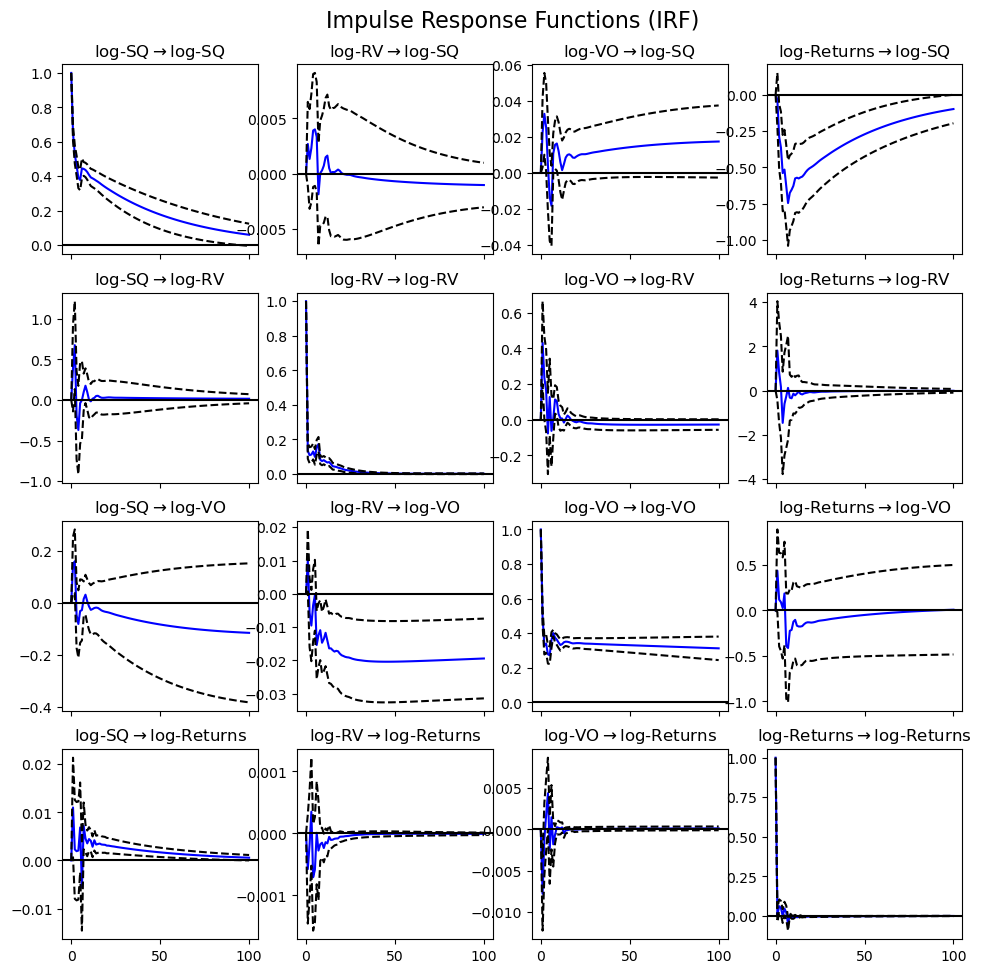


=== Subsample 1: 2012-07-01 to 2013-10-27 ===

=== Run VAR Models ===

=== Model 1 Summary ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Jan, 2025
Time:                     10:25:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.175182
Nobs:                     295.000    HQIC:                 -0.399990
Log likelihood:          -726.030    FPE:                   0.576977
AIC:                    -0.550128    Det(Omega_mle):        0.522492
--------------------------------------------------------------------
Results for equation log-RV
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -2.290002         0.971257           -2.358           0.018
L1.log-RV         0.265565         0.056356            4

In [15]:
# Trigger the main function when the script is run directly
if __name__ == "__main__":
    main()
